In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

GEMINI_KEY = os.getenv("GEMINI_PAID_KEY")

In [2]:
from PIL import Image
from typing import TypedDict, List, Optional
from langgraph.graph import StateGraph, END
from langchain_google_genai import (
    ChatGoogleGenerativeAI,
    GoogleGenerativeAIEmbeddings
)
from langchain_core.documents import Document
from qdrant_client import QdrantClient
from PIL import Image
from qdrant_client import models
from langgraph.graph import StateGraph, END

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
gemini = ChatGoogleGenerativeAI(
    model="gemini-3-pro-preview",
    temperature=0,
    api_key=GEMINI_KEY
)

In [4]:
embeddings= GoogleGenerativeAIEmbeddings(
    model= "embedding-001",
    api_key=GEMINI_KEY
)

In [5]:
qdrant= QdrantClient(
    url="http://localhost:6333"
)

Creating knowledge base

In [ ]:
from qdrant_client.models import PointStruct

topology_kb=[
    Document(page_content=""" 
    You are a CAD topology extraction expert.
    Analyze the PROVIDED ORIGINAL CAD IMAGE (NOT recolored).

    Output STRICT JSON inside markers.
    No explanation.

    <<<TOPOLOGY_START>>>
    {
    "views": [
        {
        "view": "front",
        "outer_closed_loops": [
            {
            "loop_id": 1,
            "region": "MATERIAL",
            "nodes": 4,
            "edges": 4,
            "edge_type": {
                "straight": 4,
                "chamfer": 0
            }
            }
        ],
        "inner_closed_loops": [
            {
            "loop_id": 2,
            "region": "VOID",
            "nodes": 0,
            "edges": 0,
            "type": "Circle"
            }
        ]
        }
    ]
    }
    <<<TOPOLOGY_END>>>
    """),

    #Text Chunks for explicit rules
    Document(page_content="Inner loops are always VOID, outer loops are always MATERIAL."),
    Document(page_content="If entity is Circle: nodes = 0, edges = 0, only mention the type."),

    #Text chunks for feature-to-topology mapping
    Document(page_content="Rectangle → 4 nodes, 4 straight edges"),
    Document(page_content="Fillet → rounded edge replacing sharp corner"),
    Document(page_content="Chamfer → angled edge replacing corner")

]

#Create qdrant collection
qdrant.recreate_collection(
    collection_name="topology_rules",
    vectors_config={
        "size": 768,
        "distance": "Cosine"
    }
)

points = []

for idx, doc in enumerate(topology_kb):
    vector = embeddings.embed_query(doc.page_content)
    
    points.append(
        PointStruct(
            id=idx,
            vector=vector,
            payload={"text": doc.page_content}
        )
    )

#Upload documents as points with embeddings
qdrant.upload_points(
    collection_name="topology_rules",
    points=points
)

print("Topology knowledge base updated in Qdrant RAG.")

/var/folders/wl/8x04_m0j1rl9z6rkvjyrqvkc0000gn/T/ipykernel_9957/1850222940.py:55: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  qdrant.recreate_collection(


Topology knowledge base updated in Qdrant RAG.


## Langgraph state

In [7]:
class CADState (TypedDict):
    image_path: str
    visual_features: Optional[str]
    decision: Optional[str]
    retrieved_rules: Optional[List[str]]
    topology_output: Optional[str]

### Feature Extraction

Nodel 1

In [8]:
import base64
import mimetypes

def extract_features(state: CADState):
    image_path = state["image_path"]
    
    with open(image_path, "rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode("utf-8")
    
    mime_type, _ = mimetypes.guess_type(image_path)
    data_uri = f"data:{mime_type or 'image/png'};base64,{base64_image}"

    response = gemini.invoke([
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Analyze the CAD topology of this image..."},
                {"type": "image_url", "image_url": data_uri}
            ],
        }
    ])

    # FORCE CONTENT TO STRING to prevent ValidationError in embeddings
    content = response.content
    if isinstance(content, list):
        content = " ".join([c if isinstance(c, str) else c.get("text", "") for c in content])
    elif isinstance(content, dict):
        content = content.get("text", "")

    return {"visual_features": str(content)}

node 2 (decide if we need RAG)

In [9]:
def decide_topology(state: CADState):
    prompt = f"""
    Given the extracted visual features:
    {state['visual_features']}

    Should topology rules be applied?
    Answer ONLY "YES" or "NO".
    """

    response = gemini.invoke(prompt)
    content = response.content
    
    # 1. Handle if content is a list of parts/dicts
    if isinstance(content, list):
        content = content[0] if content else ""
        
    # 2. Handle if content is a dictionary
    if isinstance(content, dict):
        content = content.get("text", "")

    # Convert to string and clean it up
    decision_text = str(content).strip().upper()
    
    # Ensure it's strictly YES or NO to avoid logic errors
    if "YES" in decision_text:
        decision_text = "YES"
    elif "NO" in decision_text:
        decision_text = "NO"

    return {
        "decision": decision_text
    }

Node 3 (RAG retrieval)

In [10]:
def retrieve_topology_rules(state: CADState):
    query_text = str(state["visual_features"])
    query_vector = embeddings.embed_query(query_text)

    # Use the newer .query_points() or .search() 
    hits = qdrant.query_points(
        collection_name="topology_rules",
        query=query_vector,
        limit=3
    ).points

    rules = [hit.payload["text"] for hit in hits]
    return {
        "retrieved_rules": rules 
    }

node 4 (Gemini reasoning)

In [11]:
def generate_topology(state: CADState):
    # retrieved_rules is the context retrieved from Qdrant
    prompt = f"""
Using:
Visual Features:
{state['visual_features']}

Topology Rules:
{state['retrieved_rules']}

Note that if the entity is circle, nodes= 0 and edges= 0
Generate structured topological information in JSON.
Include:
- entity_type
- relationships
"""

    response = gemini.invoke(prompt)

    return {
        "topology_output": response.content
    }

In [12]:
def should_retrieve(state: CADState):
    return state["decision"] == "YES"

## Graph

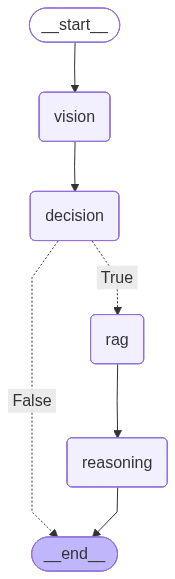

In [13]:
graph= StateGraph(CADState)

graph.add_node("vision", extract_features)
graph.add_node("decision", decide_topology)
graph.add_node("rag", retrieve_topology_rules)
graph.add_node("reasoning", generate_topology)

graph.set_entry_point("vision")

graph.add_edge("vision", "decision")
graph.add_conditional_edges(
    "decision",
    should_retrieve,{
        True: "rag",
        False: END
    }
)

graph.add_edge("rag", "reasoning")
graph.add_edge("reasoning", END)

app=graph.compile() 
app

In [15]:
result = app.invoke(
    {
        "image_path": "/Users/naswahmanandhar/Desktop/RAG/images/2.png"
    }
)

print("===== TOPOLOGY OUTPUT =====")
print(result["topology_output"])

===== TOPOLOGY OUTPUT =====
[{'type': 'text', 'text': '<<<TOPOLOGY_START>>>\n{\n  "views": [\n    {\n      "view": "front",\n      "outer_closed_loops": [\n        {\n          "loop_id": 1,\n          "region": "MATERIAL",\n          "nodes": 4,\n          "edges": 4,\n          "edge_type": {\n            "straight": 4,\n            "chamfer": 0\n          }\n        }\n      ],\n      "inner_closed_loops": [\n        {\n          "loop_id": 2,\n          "region": "VOID",\n          "nodes": 0,\n          "edges": 0,\n          "type": "Circle"\n        },\n        {\n          "loop_id": 3,\n          "region": "VOID",\n          "nodes": 0,\n          "edges": 0,\n          "type": "Circle"\n        }\n      ]\n    },\n    {\n      "view": "side",\n      "outer_closed_loops": [\n        {\n          "loop_id": 1,\n          "region": "MATERIAL",\n          "nodes": 4,\n          "edges": 4,\n          "edge_type": {\n            "straight": 4,\n            "chamfer": 0\n          